In [1]:
using Knet, CUDA,Images, Random, Statistics,Base,NPZ,Plots
const F = Float32
Atype = CUDA.functional() ? KnetArray{F} : Array{F};

include("model.jl")
include("utils.jl")
using .model
using .utils

In [2]:
function inference_forward(w,x,y_hat,data_mean,data_std,n)
    wdec, wenc = w[:decoder], w[:encoder]
    x_normalized = (x .- data_mean)./ data_std
    mu, logvar = encode(wenc, x_normalized)
    y_total = Atype(zeros(Float32,size(x)))
    for i in 1:n
        z = reparameterize(mu,logvar)
        y = decode(wdec,z)
        y  = (y.*data_std) .+ data_mean
        y_total = y_total .+ y
    end
    y_total = y_total./n
    return MSE(y_hat,y_total)
end

inference_forward (generic function with 1 method)

##### for 1000 samples I did not run model 5 times  since it takes more time (I will share the results over 5 runs soon)

# Fully Unsupervised

##  1 ) W2S Avg 1 Channel 0 

In [3]:
channel = 0
avg = 1
dataset = string("w2s_avg",avg, "_channel_",channel)
train_data = npzread("../../Datasets/"*dataset*".npz");

In [4]:
xtrn=train_data["train"];
xval=train_data["val"];
xtst=train_data["test_GT"];
test_noisy = train_data["test"]
xtrn=permutedims(xtrn, [2, 3, 1]);
xval=permutedims(xval, [2, 3, 1]);
xtst=permutedims(xtst, [2, 3, 1]);
test_noisy=permutedims(test_noisy, [2, 3, 1]);
dtst = minibatch(test_noisy,xtst, 1; xsize = (512, 512, 1,:),ysize = (512, 512, 1,:), xtype = Atype,ytype=Atype);
data_mean,data_std = get_dataset_mean_std(xtrn,xval)

(144.5471845626831, 64.29629807886549)

In [5]:
w = Knet.load(dataset*"_best.jld2","w",);

In [6]:
psnr_list_10 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,10)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_10,psnr)
end

psnr_list_100 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,100)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_100,psnr)
end

psnr_list_1000 = []
for i =1:1
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,1000)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_1000,psnr)
end

In [7]:
println.([psnr_list_10,psnr_list_100,psnr_list_1000]);

Any[33.949127f0, 33.935364f0, 33.940853f0, 33.970364f0, 33.921623f0]
Any[34.32955f0, 34.32805f0, 34.324783f0, 34.331505f0, 34.327484f0]
Any[34.366585f0]


In [8]:
println("mean PSNR and std over 5 runs (1000 samples results are over one run)\n")
println("Paper Reported Result")
println("1000 samples MMSE estimate : mean : 34.24 std :0.006")
println("-------------------\n")
println("10 samples MMSE estimate : mean : "*string(mean(psnr_list_10))*" std "*string(std(psnr_list_10)))
println("100 samples MMSE estimate : mean : "*string(mean(psnr_list_100))*" std "*string(std(psnr_list_100)))
println("1000 samples MMSE estimate  : mean : "*string(mean(psnr_list_1000))*" std "*string(std(psnr_list_1000)))

mean PSNR and std over 5 runs (1000 samples results are over one run)

Paper Reported Result
1000 samples MMSE estimate : mean : 34.24 std :0.006
-------------------

10 samples MMSE estimate : mean : 33.94347 std 0.01806316
100 samples MMSE estimate : mean : 34.328274 std 0.0024965066
1000 samples MMSE estimate  : mean : 34.366585 std NaN


In [9]:
trn_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_recon_loss_fully_unsupervised.jld2","trn_recon_loss",)
trn_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_KLD_loss_fully_unsupervised.jld2","trn_KLD_loss",)
val_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_val_recon_loss_fully_unsupervised.jld2","val_recon_loss",)
val_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_val_KLD_loss_fully_unsupervised.jld2","val_KLD_loss",);

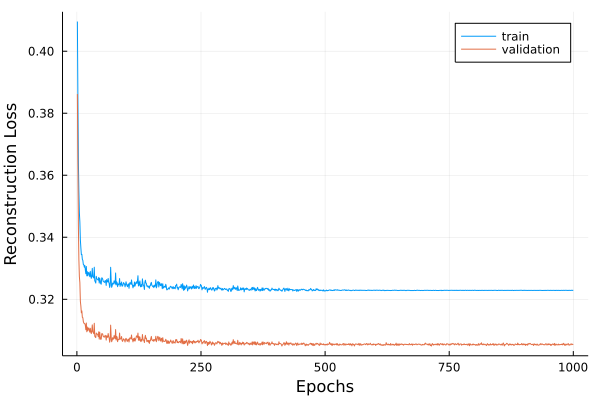

In [10]:
plot([trn_recon_loss, val_recon_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Reconstruction Loss")

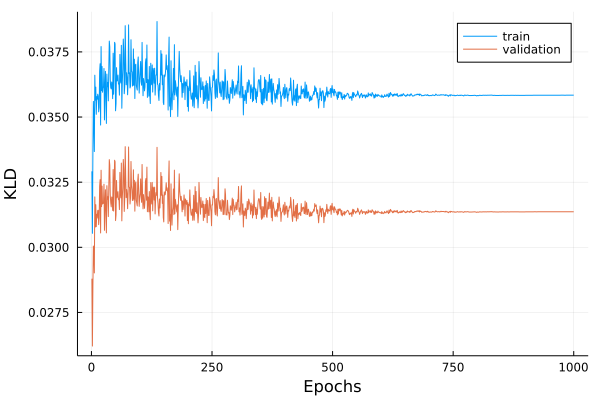

In [11]:
plot([trn_KLD_loss, val_KLD_loss],#ylim=(0.0,0.5),
     labels=["train" "validation"],xlabel="Epochs",ylabel="KLD")

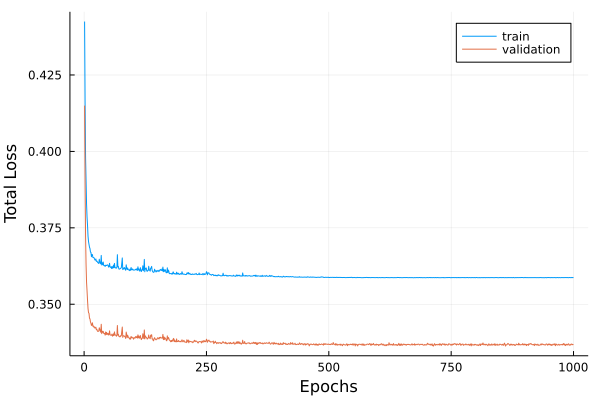

In [12]:
plot([trn_recon_loss.+trn_KLD_loss, val_recon_loss.+val_KLD_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Total Loss")

##  2 ) W2S Avg 1 Channel 1

In [13]:
channel = 1
avg = 1
dataset = string("w2s_avg",avg, "_channel_",channel)
train_data = npzread("../../Datasets/"*dataset*".npz");

In [14]:
xtrn=train_data["train"];
xval=train_data["val"];
xtst=train_data["test_GT"];
test_noisy = train_data["test"]
xtrn=permutedims(xtrn, [2, 3, 1]);
xval=permutedims(xval, [2, 3, 1]);
xtst=permutedims(xtst, [2, 3, 1]);
test_noisy=permutedims(test_noisy, [2, 3, 1]);
dtst = minibatch(test_noisy,xtst, 1; xsize = (512, 512, 1,:),ysize = (512, 512, 1,:), xtype = Atype,ytype=Atype);
data_mean,data_std = get_dataset_mean_std(xtrn,xval)

(181.69353284835816, 79.60961573970181)

In [15]:
w = Knet.load(dataset*"_best.jld2","w",);

In [16]:
psnr_list_10 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,10)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_10,psnr)
end

psnr_list_100 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,100)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_100,psnr)
end

psnr_list_1000 = []
for i =1:1
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,1000)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_1000,psnr)
end

In [17]:
println.([psnr_list_10,psnr_list_100,psnr_list_1000]);

Any[31.799402f0, 31.784054f0, 31.777039f0, 31.779373f0, 31.784588f0]
Any[32.201794f0, 32.204857f0, 32.20311f0, 32.204937f0, 32.202904f0]
Any[32.24682f0]


In [18]:
println("mean PSNR and std over 5 runs (1000 samples results are over one run)\n")
println("Paper Reported Result")
println("1000 samples MMSE estimate : mean : 32.22 std :0.021")
println("-------------------\n")
println("10 samples MMSE estimate : mean : "*string(mean(psnr_list_10))*" std "*string(std(psnr_list_10)))
println("100 samples MMSE estimate : mean : "*string(mean(psnr_list_100))*" std "*string(std(psnr_list_100)))
println("1000 samples MMSE estimate  : mean : "*string(mean(psnr_list_1000))*" std "*string(std(psnr_list_1000)))

mean PSNR and std over 5 runs (1000 samples results are over one run)

Paper Reported Result
1000 samples MMSE estimate : mean : 32.22 std :0.021
-------------------

10 samples MMSE estimate : mean : 31.784891 std 0.008710279
100 samples MMSE estimate : mean : 32.20352 std 0.0013530861
1000 samples MMSE estimate  : mean : 32.24682 std NaN


In [19]:
trn_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_recon_loss_fully_unsupervised.jld2","trn_recon_loss",)
trn_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_KLD_loss_fully_unsupervised.jld2","trn_KLD_loss",)
val_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_val_recon_loss_fully_unsupervised.jld2","val_recon_loss",)
val_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_val_KLD_loss_fully_unsupervised.jld2","val_KLD_loss",);

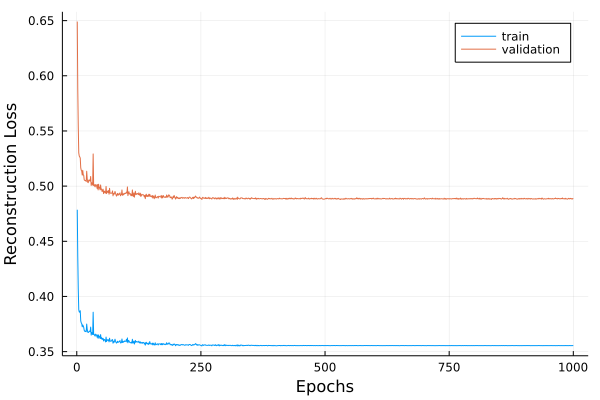

In [20]:
plot([trn_recon_loss, val_recon_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Reconstruction Loss")

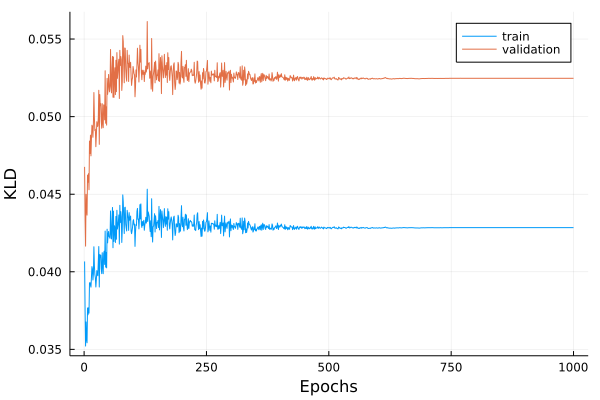

In [21]:
plot([trn_KLD_loss, val_KLD_loss],#ylim=(0.0,0.5),
     labels=["train" "validation"],xlabel="Epochs",ylabel="KLD")

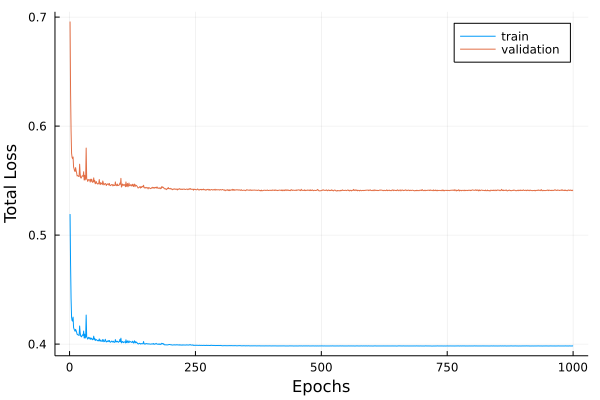

In [22]:
plot([trn_recon_loss.+trn_KLD_loss, val_recon_loss.+val_KLD_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Total Loss")

##  3 ) W2S Avg 1 Channel 2

In [23]:
channel = 2
avg = 1
dataset = string("w2s_avg",avg, "_channel_",channel)
train_data = npzread("../../Datasets/"*dataset*".npz");

In [24]:
xtrn=train_data["train"];
xval=train_data["val"];
xtst=train_data["test_GT"];
test_noisy = train_data["test"]
xtrn=permutedims(xtrn, [2, 3, 1]);
xval=permutedims(xval, [2, 3, 1]);
xtst=permutedims(xtst, [2, 3, 1]);
test_noisy=permutedims(test_noisy, [2, 3, 1]);
dtst = minibatch(test_noisy,xtst, 1; xsize = (512, 512, 1,:),ysize = (512, 512, 1,:), xtype = Atype,ytype=Atype);
data_mean,data_std = get_dataset_mean_std(xtrn,xval)

(160.96669211387635, 62.187794918160826)

In [25]:
w = Knet.load(dataset*"_best.jld2","w",);

In [26]:
psnr_list_10 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,10)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_10,psnr)
end

psnr_list_100 = []
for i =1:5
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,100)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_100,psnr)
end

psnr_list_1000 = []
for i =1:1
    PSNR_total = 0
    for (i,x)  in enumerate(dtst)
        noisy,y = x
        mse = inference_forward(w,noisy,y,data_mean,data_std,1000)
        min_y = minimum(y)
        max_y = maximum(y)
        PSNR_total += 10*Base.log10(((max_y-min_y)^2)/mse)
    end
    psnr = PSNR_total/length(dtst)
    push!(psnr_list_1000,psnr)
end

In [27]:
println.([psnr_list_10,psnr_list_100,psnr_list_1000]);

Any[34.84433f0, 34.83873f0, 34.850044f0, 34.847023f0, 34.86199f0]
Any[35.267082f0, 35.262825f0, 35.267445f0, 35.2743f0, 35.266914f0]
Any[35.31086f0]


In [28]:
println("mean PSNR and std over 5 runs (1000 samples results are over one run)\n")
println("Paper Reported Result")
println("1000 samples MMSE estimate : mean : 35.24 std :0.028")
println("-------------------\n")
println("10 samples MMSE estimate : mean : "*string(mean(psnr_list_10))*" std "*string(std(psnr_list_10)))
println("100 samples MMSE estimate : mean : "*string(mean(psnr_list_100))*" std "*string(std(psnr_list_100)))
println("1000 samples MMSE estimate  : mean : "*string(mean(psnr_list_1000))*" std "*string(std(psnr_list_1000)))

mean PSNR and std over 5 runs (1000 samples results are over one run)

Paper Reported Result
1000 samples MMSE estimate : mean : 35.24 std :0.028
-------------------

10 samples MMSE estimate : mean : 34.848427 std 0.008651792
100 samples MMSE estimate : mean : 35.26771 std 0.0041347235
1000 samples MMSE estimate  : mean : 35.31086 std NaN


In [29]:
trn_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_recon_loss_fully_unsupervised.jld2","trn_recon_loss",)
trn_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_trn_KLD_loss_fully_unsupervised.jld2","trn_KLD_loss",)
val_recon_loss = Knet.load("recon_kld_loss/"*dataset*"_val_recon_loss_fully_unsupervised.jld2","val_recon_loss",)
val_KLD_loss = Knet.load("recon_kld_loss/"*dataset*"_val_KLD_loss_fully_unsupervised.jld2","val_KLD_loss",);

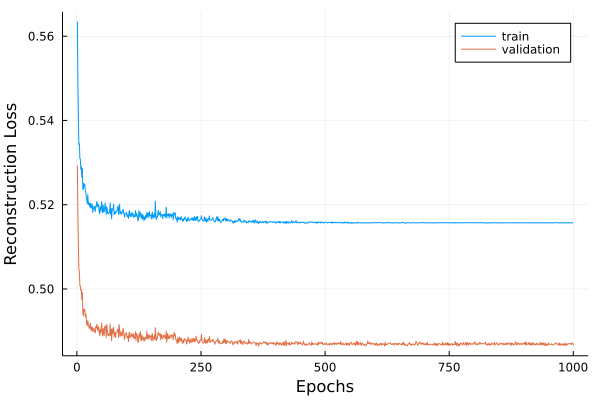

In [30]:
plot([trn_recon_loss, val_recon_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Reconstruction Loss")

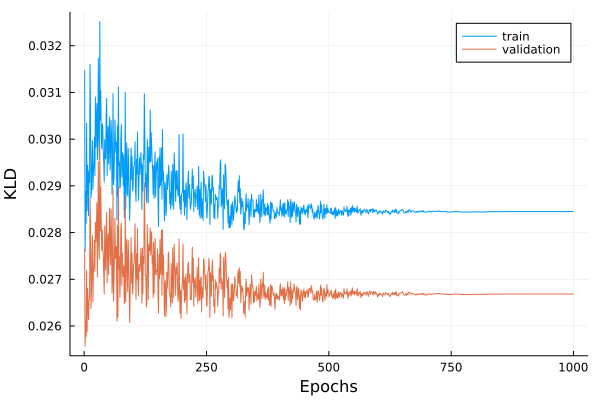

In [31]:
plot([trn_KLD_loss, val_KLD_loss],#ylim=(0.0,0.5),
     labels=["train" "validation"],xlabel="Epochs",ylabel="KLD")

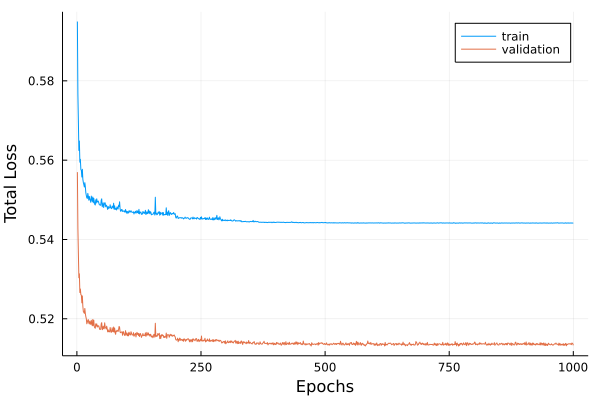

In [32]:
plot([trn_recon_loss.+trn_KLD_loss, val_recon_loss.+val_KLD_loss],#ylim=(0.65,1.0),
     labels=["train" "validation"],xlabel="Epochs",ylabel="Total Loss")